# Week 11 Day 2: Fast Fourier Transform (FFT)

## Objectives

* Learn a bit about the way a FFT works
* Cover two methods to implement the Cooly-Tukey FFT
* Mention compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

### The Fast Fourier Transform

The FFT has been called one of the 10 most important algorithms of our time. Let's take a second to look at the pair of lists [available here](https://nickhigham.wordpress.com/2016/03/29/the-top-10-algorithms-in-applied-mathematics/):

| 2016 PCAM index | 2000 Computing in Science and Engineering |
|----------------------------------------|------------------------|
| Newton and quasi-Newton methods        | The Fortran Optimizing Compiler |
| Matrix factorizations (LU, Cholesky, QR) | --- |
| Singular value decomposition, QR and QZ algorithms| --- |
| Monte-Carlo methods                    | --- |
| Fast Fourier transform                 | --- |
| Krylov subspace methods (conjugate gradients, Lanczos, GMRES, minres) | --- |
| JPEG                                   | Quicksort algorithm for sorting |
| PageRank                               | Integer relation detection |
| Simplex algorithm                      | --- |
| Kalman filter                          | Fast multipole method |

(The items that match are marked with ---). Both lists prominently feature the FFT.

Why is FFT so important? Let's look at performance. A way to relate different algorithms is the order, $\mathcal{O}$. This gives you an idea of how the algorithm grows with the size of the problem - it says nothing about the overall time. Hopefully, overall speed is optimal for an algorithm; maybe we are using Numba or something like that; but even if you are not, the order still holds between similar implementations. The order really describes the number of operations an algorithm requires, but that should be related to the time.

Assuming you have N elements,

* $\mathcal{O}(1)$: Does not depend on the number of elements at all, just takes a constant amount of time.
* $\mathcal{O}(N)$: Doubling the number of elements doubles the about of time
* $\mathcal{O}(N^2)$: Doubling the number of elements quadruples the about of time

Etc.

If you look at the DFT algorithm, you'll see it has $N\times N$ calculations, so it is order $\mathcal{O}(N^2)$. This means for $N=1,000$ elements, you would need $1,000,000$ calculations (where "calculations" has an unspecified size). FFTs are order $\mathcal{O}(N \log_2 N)$ instead. So, since $1024 = 2^{10}$, this is roughly $1000\times 10 = 10,000$ calculations - that's 100 times faster. Feel free to repeat the calculation with $1,000,000$ elements, which is not unreasonable for an FT problem.

Let's revisit the DFT algorithm:

$$
Z = e^{-2 \pi i / N} \\
Y_n = \frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N-1} Z^{n k} y_k
$$

Here we have adjusted the formula from last time slightly to ensure both $n$ and $k$ start at 0. (The book seems to have an error here, because in later discussions the k's start from 0.)
Since both $n$ and $k$ vary over $N$ values, this is $N^2$ calculations. Let's investigate the most popular FFT algorithm, the Cooley–Tukey FFT. This one requires you have a power of 2 number of elements. Other FFT algorithms exist - but you can always "pad" your data to the next power of two and use this one.

### Cooly-Tukey FFT

Our approach is a bit different in the book, feel free to look at that too.

We can break the DFT calculation into two pieces, the even $k$ terms and the odd $k$:

$$
Y_n =
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z^{n (2 k)} y_{2 k} +
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z^{n (2 k + 1)} y_{2 k + 1}
$$

We can then make two definitions here:

$$
E_n \equiv  \frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z^{n (2 k)} y_{2 k} \\
O_n \equiv  \frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z^{n (2 k)} y_{2 k + 1}
$$

So the above expression becomes:

$$
Y_n = E_n + Z^n O_n
$$

Given that this is periodic, we can also compute $Y_{n+N/2}$:

$$
Y_{n+N/2} =
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z^{(n+N/2) (2 k)} y_{2 k} +
\frac{1}{\sqrt{2 \pi}} \sum_{k=0}^{N/2 - 1} Z^{(n+N/2) (2 k + 1)} y_{2 k + 1}
$$

We can expand the terms in the exponents:

$$
Y_{n+N/2}=
 \frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z^{2kn}Z^{Nk}y_{2k}
+Z^{n}Z^{N/2}\frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z^{2kn}Z^{kN}y_{2k+1}
$$

However, by using our definition of $Z$, we have $Z^{kN} = e^{-2 \pi i k}$. For integer $k$, this is just 1. We can also evaluate $Z^{N/2} = e^{- \pi i} = -1$. At this point, we have now recovered the original expression, with a relative minus sign!

$$
Y_{n+N/2}=
 \frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z^{2kn}y_{2k}
-Z^{n}\frac{1}{\sqrt{2\pi}}\sum_{k=0}^{N/2-1}Z^{2kn}y_{2k+1}
$$

$$
Y_{n+N/2} = E_n - Z^n O_n
$$

So now we can split our sum into two pieces, odd and even, then combine using the above definitions to produce 2 outputs for each calculation. We could continue to break up the sum in this manor, until we have 1 item in each - this is a recursive algorithm, and it's where the $\log_2(N)$ comes from. And, one item is really simple to calculate, that's just $E_0 = y_0$ and $O_0 = y_1$ (dropping the $1/\sqrt{2 \pi}$ factor, since you can add that later).

### Recursive Cooly-Tukey FFT

Let's try it:

In [2]:
# @numba.njit
def ct_fft_recursive(x):
    N = len(x)

    if N == 1:
        return x

    Z = np.exp(-2 * np.pi * 1j / N)
    k = np.arange(N // 2)

    evens = ct_fft_recursive(x[::2])
    odds = Z ** k * ct_fft_recursive(x[1::2])

    return np.concatenate((evens + odds, evens - odds))

In [3]:
N = 2 ** 9
T = 1.0 / 800.0
x = np.linspace(0.0, N * T, N)
y = np.sin(50.0 * 2.0 * np.pi * x) + 0.5 * np.sin(80.0 * 2.0 * np.pi * x)

In [4]:
# If you want to JIT the above function, either use `return x + 0j` or the following:
y = y.astype(complex)

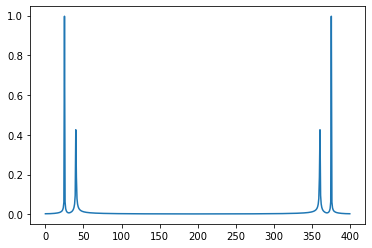

In [5]:
# Our algorithm
yf = ct_fft_recursive(y)
xf = np.linspace(0.0, 1.0 / (2.0 * T), N)
norm_yf = 2.0 / N * np.abs(yf)

plt.plot(xf, norm_yf)
plt.show()

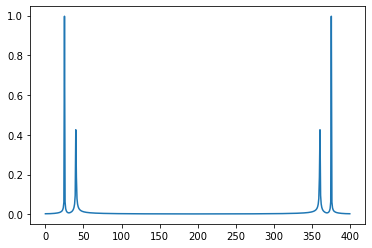

In [6]:
# Official Numpy algorithm
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0 / (2.0 * T), N)
norm_yf = 2.0 / N * np.abs(yf)

plt.plot(xf, norm_yf)
plt.show()

In [7]:
%%timeit
ct_fft_recursive(y)

4.66 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
np.fft.fft(y)

9.14 µs ± 145 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


You can get a factor 10 speed up from Numba; further gains could be obtained by avoiding the memory allocations and things like that. There are also other

### Bitflip Cooly-Tukey FFT

Like many recursive algorithms, you can also implement this in a normal loop, as well. We just need to get the ordering right - the algorithm above has a special output order: it is the same as flipping the bits on an N length binary number.


This algorithm can be best seen by looking at a feature of the above multiplication, $nk$. Let's look at a matrix of $nk$:

In [9]:
N = 8
n_or_k = np.arange(N)
nk = n_or_k.reshape(1, -1) * n_or_k.reshape(-1, 1)
for row in nk:
    print(" + ".join(f"{v: >2}" for v in row))

 0 +  0 +  0 +  0 +  0 +  0 +  0 +  0
 0 +  1 +  2 +  3 +  4 +  5 +  6 +  7
 0 +  2 +  4 +  6 +  8 + 10 + 12 + 14
 0 +  3 +  6 +  9 + 12 + 15 + 18 + 21
 0 +  4 +  8 + 12 + 16 + 20 + 24 + 28
 0 +  5 + 10 + 15 + 20 + 25 + 30 + 35
 0 +  6 + 12 + 18 + 24 + 30 + 36 + 42
 0 +  7 + 14 + 21 + 28 + 35 + 42 + 49


Notice there are lots of repeats here - this means we are doing the same calculation many times. Let's keep going. Since Z has some special properties; it is $e^{−2 \pi i/N}$, so we can use the properties that $Z^{(n-N/2)} = -Z^{n}$ and $Z^{(n-N)} = Z^{n}$ to rewrite all indices in terms of the first $N/2$ indices.

In [10]:
for row in nk:
    print(", ".join(f"{'+' if v%8 < 4 else '-'}{v%4}" for v in row))

+0, +0, +0, +0, +0, +0, +0, +0
+0, +1, +2, +3, -0, -1, -2, -3
+0, +2, -0, -2, +0, +2, -0, -2
+0, +3, -2, +1, -0, -3, +2, -1
+0, -0, +0, -0, +0, -0, +0, -0
+0, -1, +2, -3, -0, +1, -2, +3
+0, -2, -0, +2, +0, -2, -0, +2
+0, -3, -2, -1, -0, +3, +2, +1


We can now group alternating columns:

In [11]:
for row in nk:
    print(
        ", ".join(
            f"{'+' if v1%8 < 4 else '-'} "
            f"{'+' if v2%8 < 4 else '-'} "
            f"{v1%4} {v1%4}"
            for v1, v2 in zip(row[:4], row[4:])
        )
    )

+ + 0 0, + + 0 0, + + 0 0, + + 0 0
+ - 0 0, + - 1 1, + - 2 2, + - 3 3
+ + 0 0, + + 2 2, - - 0 0, - - 2 2
+ - 0 0, + - 3 3, - + 2 2, + - 1 1
+ + 0 0, - - 0 0, + + 0 0, - - 0 0
+ - 0 0, - + 1 1, + - 2 2, - + 3 3
+ + 0 0, - - 2 2, - - 0 0, + + 2 2
+ - 0 0, - + 3 3, - + 2 2, - + 1 1


If we pull the sign out, we get:

In [12]:
for row in nk:
    print(
        " ".join(
            f"{'+' if v1%8 < 4 else '-'} Z^{v1%4} "
            f"(y_{n} "
            f"{'+' if (v2%8 < 4) ^ (v1%8 >= 4) else '-'} "
            f"y_{n+4})"
            for n, v1, v2 in zip(range(4), row[:4], row[4:])
        )
    )

+ Z^0 (y_0 + y_4) + Z^0 (y_1 + y_5) + Z^0 (y_2 + y_6) + Z^0 (y_3 + y_7)
+ Z^0 (y_0 - y_4) + Z^1 (y_1 - y_5) + Z^2 (y_2 - y_6) + Z^3 (y_3 - y_7)
+ Z^0 (y_0 + y_4) + Z^2 (y_1 + y_5) - Z^0 (y_2 + y_6) - Z^2 (y_3 + y_7)
+ Z^0 (y_0 - y_4) + Z^3 (y_1 - y_5) - Z^2 (y_2 - y_6) + Z^1 (y_3 - y_7)
+ Z^0 (y_0 + y_4) - Z^0 (y_1 + y_5) + Z^0 (y_2 + y_6) - Z^0 (y_3 + y_7)
+ Z^0 (y_0 - y_4) - Z^1 (y_1 - y_5) + Z^2 (y_2 - y_6) - Z^3 (y_3 - y_7)
+ Z^0 (y_0 + y_4) - Z^2 (y_1 + y_5) - Z^0 (y_2 + y_6) + Z^2 (y_3 + y_7)
+ Z^0 (y_0 - y_4) - Z^3 (y_1 - y_5) - Z^2 (y_2 - y_6) - Z^1 (y_3 - y_7)


Notice the pattern here. The recursive nature of the pattern is what provided the previous method to work. Now let's instead expand this in loops.

First let's define a bitflip operation that reversed the order of bits; this reverses a butterfly join like the one above.

In [13]:
def bitflip(i, L):
    length = int(L)  # Expected number of bits
    str_number = f"{i:0{length}b}"  # Convert to string of 0's and 1's, correct length
    return int(str_number[::-1], 2)  # Reverse and convert to int (base 2)

In [14]:
for i in range(8):
    print(bitflip(i, np.log2(8)))  # 110 becomes 011

0
4
2
6
1
5
3
7


If converting to strings bother you, we can use bit shifts instead. Let's make this a numba function so we can make the loop function numba too if we want to.

In [15]:
@numba.njit
def bitflip(i, L):
    L = int(L)
    result = 0
    for _ in range(int(L)):
        result <<= 1
        result |= i & 1
        i >>= 1
    return result

In [16]:
for i in range(8):
    print(bitflip(i, np.log2(8)))  # 110 becomes 011

0
4
2
6
1
5
3
7


Now, we are going to need to produce three values; `p`, `first`, and `second`. This is easiest to see, I believe, if you look at figure 10.10 in the book. Let's make sure we loop properly here:

In [17]:
N = 8
times = int(np.log2(N))

for k in range(times):
    for j in range(N // 2):
        wid = 2 ** (times - k - 1)
        p = bitflip((j // wid), times - 1)
        first = (j // wid) * wid + j
        second = (j // wid) * wid + j + wid
        print(
            p, first, second,
        )
    print()

0 0 4
0 1 5
0 2 6
0 3 7

0 0 2
0 1 3
2 4 6
2 5 7

0 0 1
2 2 3
1 4 5
3 6 7



Let's put this together into our loop:

In [18]:
# @numba.njit
def ct_fft_loop(x, Z=None):
    x = x.copy()  # just to make sure we don't mess up the input
    y = x.copy()

    N = len(x)  # Number of data points
    times = int(np.log2(N))  # Number of times (the log_2 N part)

    if Z is None:  # We can support sympy too
        Z = np.exp(-2 * np.pi * 1j / N)  # with this addition.

    for k in range(times):
        wid = 2 ** (times - k - 1)
        x, y = y, x  # Trade pointers (0 copy)
        for j in range(N // 2):
            p = bitflip((j // wid), times - 1)  # The power on z
            first = (j // wid) * wid + j  # First index
            second = (j // wid) * wid + j + wid  # Second index

            left = x[first]  # Precompute terms
            right = Z ** p * x[second]

            y[first] = left + right
            y[second] = left - right

    for i in range(N):
        x[i] = y[bitflip(i, times)]

    return x

Let's just verify that this works. We'll drop Sympy variables into our algorithm and see if we get the right terms:

In [19]:
# Our algorithm
from sympy import symbols, init_printing, Matrix

init_printing()
ys = Matrix(symbols("y:8"))
Z = symbols("Z")
yf = ct_fft_loop(ys, Z)
yf

⎡         y₀ + y₁ + y₂ + y₃ + y₄ + y₅ + y₆ + y₇          ⎤
⎢                                                        ⎥
⎢   2               ⎛ 2                    ⎞             ⎥
⎢  Z ⋅(y₂ - y₆) + Z⋅⎝Z ⋅(y₃ - y₇) + y₁ - y₅⎠ + y₀ - y₄   ⎥
⎢                                                        ⎥
⎢        2                                               ⎥
⎢       Z ⋅(y₁ - y₃ + y₅ - y₇) + y₀ - y₂ + y₄ - y₆       ⎥
⎢                                                        ⎥
⎢  3 ⎛   2                    ⎞    2                     ⎥
⎢ Z ⋅⎝- Z ⋅(y₃ - y₇) + y₁ - y₅⎠ - Z ⋅(y₂ - y₆) + y₀ - y₄ ⎥
⎢                                                        ⎥
⎢         y₀ - y₁ + y₂ - y₃ + y₄ - y₅ + y₆ - y₇          ⎥
⎢                                                        ⎥
⎢   2               ⎛ 2                    ⎞             ⎥
⎢  Z ⋅(y₂ - y₆) - Z⋅⎝Z ⋅(y₃ - y₇) + y₁ - y₅⎠ + y₀ - y₄   ⎥
⎢                                                        ⎥
⎢         2                                             

In [20]:
init_printing(pretty_print=False)

Now, let's set our example back up and test it out:

In [21]:
N = 2 ** 9
T = 1.0 / 800.0
x = np.linspace(0.0, N * T, N)
y = np.sin(50.0 * 2.0 * np.pi * x) + 0.5 * np.sin(80.0 * 2.0 * np.pi * x)

In [22]:
# If you want to JIT the above function, either use `return x + 0j` or the following:
y = y.astype(complex)

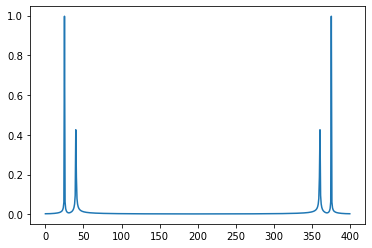

In [23]:
# Our algorithm
yf = ct_fft_loop(y)
xf = np.linspace(0.0, 1.0 / (2.0 * T), N)
norm_yf = 2.0 / N * np.abs(yf)

plt.plot(xf, norm_yf)
plt.show()

We are significanly nicer on memory, as well as avoiding lots of function calls, so we get a bit better on time. We are still not close to the official codes, however, even with numba. So, don't write your own ffts!

In [24]:
%%timeit
ct_fft_loop(y)

4.35 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%%timeit
np.fft.fft(y)

9.68 µs ± 172 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## FFTs for compression

How could an FFT be used for compression? If we truncate the series, we can throw away the high frequency components of a signal, while keeping the basic (low frequency) shape intact. Let's try:

In [26]:
x = np.linspace(-50, 50, 1000)
y = np.sin(x) / x

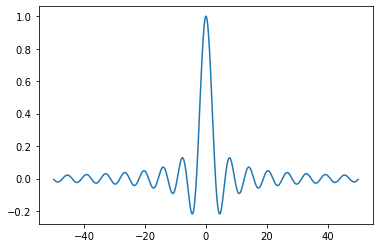

In [27]:
plt.plot(x, y)

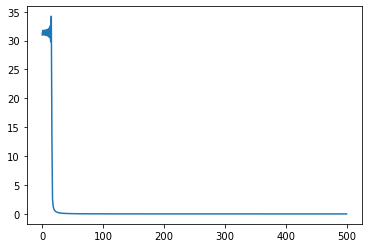

In [28]:
ft = np.fft.rfft(y)
plt.plot(np.abs(ft))

#### Lossy compression:

In [29]:
ft[30:] = 0

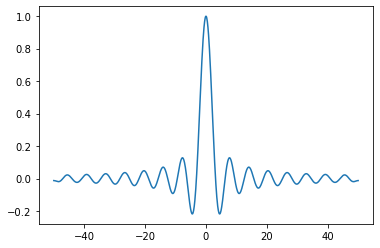

In [30]:
yp = np.fft.irfft(ft)
plt.plot(x, yp)